In [1]:
from nuisancelib import *
%matplotlib inline

In [2]:
real_files = pd.read_csv('../output/real_output.csv')
real_df = pd.DataFrame(real_files,columns=['Date', 'sid', 'ses', 'snr_total', 'TxRefAmp', 'AcquisitionTime', 'SAR',
                                'RepetitionTime', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8', 'IOPD1', 'IOPD2',
                                'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])

segstats = pd.read_csv('../output/segstats-volume.csv')
seg_df = pd.DataFrame(segstats,columns=['Date', 'sid', 'ses', 'Background', "Left-Accumbens-area", 
                                        "Left-Amygdala", "Left-Caudate", "Left-Hippocampus", "Left-Pallidum",
                                        "Left-Putamen", "Left-Thalamus-Proper", "Right-Accumbens-area", 
                                        "Right-Amygdala", "Right-Caudate", "Right-Hippocampus", "Right-Pallidum",
                                        "Right-Putamen", "Right-Thalamus-Proper", "csf", "gray", "white"])
merged_df = pd.merge(real_df, seg_df, on=['sid', 'ses'], how='outer')
merged_df['Date_x'] = pd.to_datetime(merged_df['Date_x'], format="%Y%m%d")
merged_df.set_index('Date_x',inplace=True)
# merged_df

In [3]:
# df3['Date'] = pd.to_datetime(df3['Date'], format="%Y%m%d")
df3 = pd.read_csv('../data/extractions/anat.csv', parse_dates=['Date'])
df3.set_index('Date',inplace=True)
df_reindexed = df3.reindex(pd.date_range(start=df3.index.min(), end=df3.index.max(), freq='1D'))  
df_reindexed.index.names = ['Date_x']
interpolated_df = df_reindexed.interpolate(method='time')
# interpolated_df

In [4]:
super_df = pd.merge(merged_df, interpolated_df, left_index=True, right_index=True, suffixes = ("_real", "_qa"))
# super_df

In [5]:
demographic_df = pd.read_csv('../data/dbic/bids/participants.tsv', sep='\t')
demographic_df = demographic_df.rename(index=str, columns={"participant_id": "sid"})
final_df = super_df.join(demographic_df.set_index('sid'), on='sid', how='left')
# final_df

In [6]:
# need to slice a prepared DataFrame first
real_data_df = pd.DataFrame(final_df,columns=['gray', 'age', 'sex', 'snr_total_qa'])
real_data_df = real_data_df.reset_index()
real_data_df = real_data_df.rename(columns={'Date_x': 'Date'})
real_data_df['sex_male'] = [0 for item in range(len(real_data_df))]
real_data_df.sex_male[real_data_df.sex == 'M'] = int(1)
# real_data_df

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
# 'Background', "Left-Accumbens-area", 
#                                         "Left-Amygdala", "Left-Caudate", "Left-Hippocampus", "Left-Pallidum",
#                                         "Left-Putamen", "Left-Thalamus-Proper", "Right-Accumbens-area", 
#                                         "Right-Amygdala", "Right-Caudate", "Right-Hippocampus", "Right-Pallidum",
#                                         "Right-Putamen", "Right-Thalamus-Proper", "csf", "gray", "white"
amyg_data_df = pd.DataFrame(final_df,columns=['csf', 'age', 'sex', 'snr_total_qa'])
amyg_data_df = amyg_data_df.reset_index()
amyg_data_df = amyg_data_df.rename(columns={'Date_x': 'Date'})
amyg_data_df['sex_male'] = [0 for item in range(len(amyg_data_df))]
amyg_data_df.sex_male[amyg_data_df.sex == 'M'] = int(1)
# amyg_data_df

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [8]:
expanded_df = pd.DataFrame(final_df,columns=['sid', 'ses', 'Background', "Left-Accumbens-area", 
                                        "Left-Amygdala", "Left-Caudate", "Left-Hippocampus", "Left-Pallidum",
                                        "Left-Putamen", "Left-Thalamus-Proper", "Right-Accumbens-area", 
                                        "Right-Amygdala", "Right-Caudate", "Right-Hippocampus", "Right-Pallidum",
                                        "Right-Putamen", "Right-Thalamus-Proper", "csf", "gray", "white", 'age', 
                                             'sex', 'snr_total_qa', 'IOPD1_real', 'IOPD2_real', 'IOPD3_real', 
                                             'IOPD4_real', 'IOPD5_real', 'IOPD6_real'])
expanded_df = expanded_df.reset_index()
expanded_df = expanded_df.rename(columns={'Date_x': 'Date'})
expanded_df['sex_male'] = [0 for item in range(len(expanded_df))]
expanded_df.sex_male[expanded_df.sex == 'M'] = int(1)
# expanded_df

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [9]:
df = pd.read_csv('../data/extractions/p2_BOLD.csv', parse_dates=['Date'])
tsnr_df = pd.DataFrame(df,columns=['Date', 'tsnr'])
tsnr_df.set_index('Date',inplace=True)
tsnr_df_reindexed = tsnr_df.reindex(pd.date_range(start=tsnr_df.index.min(), end=tsnr_df.index.max(), freq='1D'))  
tsnr_df_reindexed.index.names = ['Date']
interpolated_tsnr_df = tsnr_df_reindexed.interpolate(method='time')
# interpolated_tsnr_df

new_df = pd.merge(interpolated_tsnr_df, expanded_df, on=['Date'], how='right')
# new_df

In [10]:
dicom_data = pd.read_csv('../output/dicom_data.csv')
dicom_data = pd.DataFrame(dicom_data,columns=['sid', 'ses', 'PatientWeight'])
July17_df = pd.merge(new_df, dicom_data, on=['sid', 'ses'], how='left')
# July17_df

In [11]:
Oct14_df = pd.DataFrame(July17_df,columns=['Date', 'gray', 'age', 'snr_total_qa', 'IOPD1_real', 'IOPD2_real', 'IOPD3_real', 
                                              'IOPD4_real', 'IOPD5_real', 'IOPD6_real', 'sex_male', 'PatientWeight', 
                                              'Seasonal (sin)', 'Seasonal (cos)'])

/Users/chrischeng/nuisance/ipy/nuisancelib.py:140: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  model_array = orthogonalize(orthogonalized_df.as_matrix())
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


No Shim variables in the model
IOPD F-test: <F test: F=array([[3.97635428]]), p=0.000809646168105453, df_denom=248, df_num=6>
Seasonal F-test: <F test: F=array([[3.79081805]]), p=0.023896391642551047, df_denom=248, df_num=2>
Statistically significant variables: ['IOPD1', 'IOPD2', 'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6', 'const', 'age', 'IOPD2_real', 'IOPD3_real', 'IOPD6_real', 'PatientWeight', 'Seasonal (sin)', 'snr_total_qa']
                            OLS Regression Results                            
Dep. Variable:                   gray   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     6.615
Date:                Mon, 18 Nov 2019   Prob (F-statistic):           2.92e-10
Time:                        15:21:28   Log-Likelihood:                -3509.2
No. Observations:                 261   AIC:                             7044.
Df Residuals:        

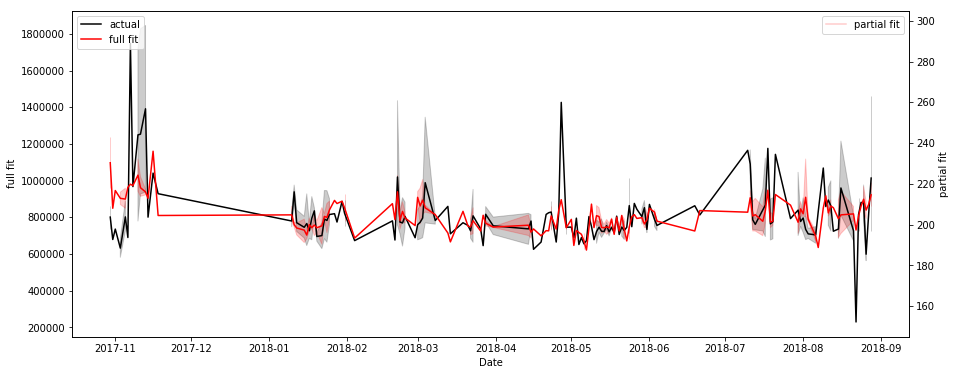

In [12]:
# WITH BOTH SNR_TOTAL_QA AND SEASONAL DATA
hello = regress('gray', Oct14_df, qa=False, real_data = True)

/Users/chrischeng/nuisance/ipy/nuisancelib.py:140: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  model_array = orthogonalize(orthogonalized_df.as_matrix())
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


No Shim variables in the model
IOPD F-test: <F test: F=array([[3.82777208]]), p=0.0011391823330802217, df_denom=250, df_num=6>
No Seasonal variables in the model
Statistically significant variables: ['IOPD1', 'IOPD2', 'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6', 'const', 'age', 'IOPD2_real', 'IOPD3_real', 'IOPD6_real', 'PatientWeight', 'snr_total_qa']
                            OLS Regression Results                            
Dep. Variable:                   gray   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     6.514
Date:                Mon, 18 Nov 2019   Prob (F-statistic):           6.12e-09
Time:                        15:22:04   Log-Likelihood:                -3515.2
No. Observations:                 261   AIC:                             7052.
Df Residuals:                     250   BIC:                             7092.
Df Model:              

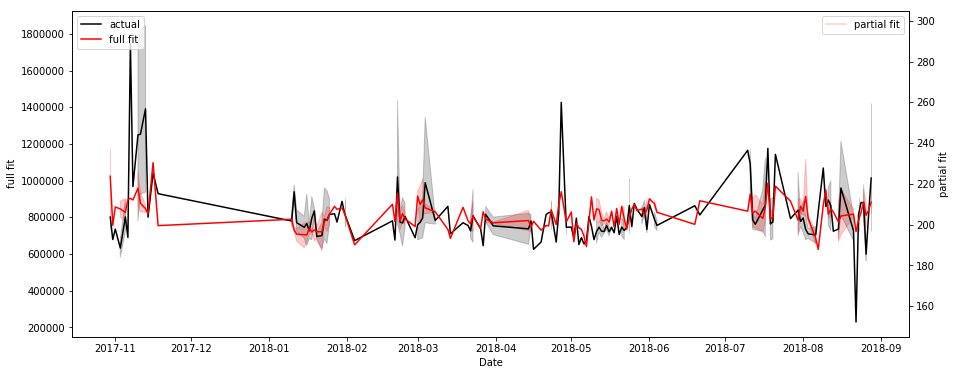

In [12]:
# WITH ONLY SNR_TOTAL_QA
regress('gray', Oct14_df, qa=False, real_data = True)

/Users/chrischeng/nuisance/ipy/nuisancelib.py:140: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  model_array = orthogonalize(orthogonalized_df.as_matrix())
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


No Shim variables in the model
IOPD F-test: <F test: F=array([[3.81942467]]), p=0.001162893595425604, df_denom=249, df_num=6>
Seasonal F-test: <F test: F=array([[3.64121075]]), p=0.02762649411197613, df_denom=249, df_num=2>
Statistically significant variables: ['IOPD1', 'IOPD2', 'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6', 'const', 'age', 'IOPD2_real', 'IOPD3_real', 'IOPD6_real', 'PatientWeight', 'Seasonal (sin)']
                            OLS Regression Results                            
Dep. Variable:                   gray   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     5.951
Date:                Mon, 18 Nov 2019   Prob (F-statistic):           1.34e-08
Time:                        15:22:40   Log-Likelihood:                -3515.0
No. Observations:                 261   AIC:                             7054.
Df Residuals:                     249 

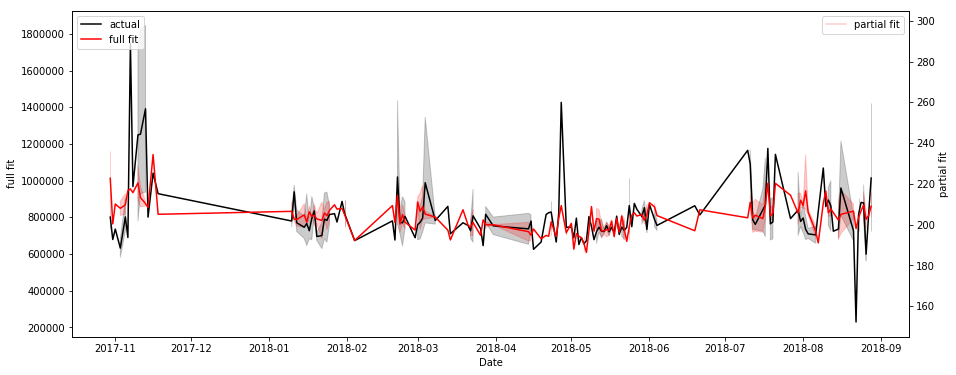

In [12]:
# WITH ONLY SEASONAL
regress('gray', Oct14_df, qa=False, real_data = True)

/Users/chrischeng/nuisance/ipy/nuisancelib.py:140: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  model_array = orthogonalize(orthogonalized_df.as_matrix())
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


No Shim variables in the model
IOPD F-test: <F test: F=array([[3.74069976]]), p=0.0013914338578485722, df_denom=251, df_num=6>
No Seasonal variables in the model
Statistically significant variables: ['IOPD1', 'IOPD2', 'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6', 'const', 'age', 'IOPD2_real', 'IOPD3_real', 'IOPD6_real', 'PatientWeight']
                            OLS Regression Results                            
Dep. Variable:                   gray   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     6.331
Date:                Mon, 18 Nov 2019   Prob (F-statistic):           4.43e-08
Time:                        15:23:18   Log-Likelihood:                -3518.8
No. Observations:                 261   AIC:                             7058.
Df Residuals:                     251   BIC:                             7093.
Df Model:                           9  

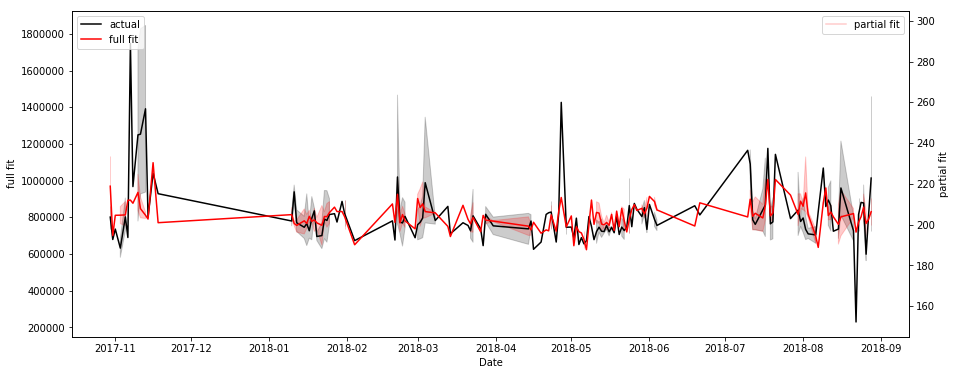

In [12]:
# WITH NEITHER SEASONAL OR SNR_TOTAL_QA
regress('gray', Oct14_df, qa=False, real_data = True)

In [12]:
targets = ['Background', "Left-Accumbens-area", "Left-Amygdala", "Left-Caudate", "Left-Hippocampus", "Left-Pallidum",
                                        "Left-Putamen", "Left-Thalamus-Proper", "Right-Accumbens-area", 
                                        "Right-Amygdala", "Right-Caudate", "Right-Hippocampus", "Right-Pallidum",
                                        "Right-Putamen", "Right-Thalamus-Proper", "csf", "gray", "white"]
scrape_var_significance(targets, 'snr_total_qa', July17_df)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


,Variable,snr_total_qa p value,R2 value
0,Background,0.259286,0.471313
1,Left-Accumbens-area,0.995750,0.104321
2,Left-Amygdala,0.405325,0.330284
3,Left-Caudate,0.110944,0.219234
4,Left-Hippocampus,0.320920,0.218041
5,Left-Pallidum,0.576059,0.521950
6,Left-Putamen,0.461739,0.270311
7,Left-Thalamus-Proper,0.260049,0.431581
8,Right-Accumbens-area,0.399768,0.149502
9,Right-Amygdala,0.525882,0.335799


In [13]:
scrape_var_significance(targets, 'Seasonal', July17_df)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


,Variable,Seasonal p value,R2 value
0,Background,0.05540799989366439,0.471313
1,Left-Accumbens-area,0.732362904892712,0.104321
2,Left-Amygdala,0.3233681353612082,0.330284
3,Left-Caudate,0.4150558781370003,0.219234
4,Left-Hippocampus,0.2654839588682769,0.218041
5,Left-Pallidum,0.029567214243339426,0.521950
6,Left-Putamen,0.025511180165074383,0.270311
7,Left-Thalamus-Proper,0.09719711572452319,0.431581
8,Right-Accumbens-area,0.026752320463728177,0.149502
9,Right-Amygdala,0.9442760922053602,0.335799
